In [1]:
import os
import zipfile
import re
import subprocess
import csv
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Dict, Any, Literal, List, Optional, Tuple
import dotenv
import json
import yaml
import time
import glob
import hashlib
import shutil
import logging
import matplotlib.pyplot as plt

from PIL import Image
from transformers import pipeline
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from sentence_transformers import SentenceTransformer

from config import cfg
from yacs.config import CfgNode
from model import make_model
from utils.re_ranking import re_ranking
from data.build_DG_dataloader import build_reid_test_loader
from processor.ori_vit_processor_with_amp import do_inference as do_inf
from processor.part_attention_vit_processor import do_inference as do_inf_pat

import torch
from transformers import AutoModel
import torch.nn.functional as F
from transformers.models.dinov2 import Dinov2Model

config_train_b = "config/UrbanElementsReID_train.yml"
config_test_b = "config/UrbanElementsReID_test.yml"

config_train_embedding_r = "config/UrbanElementsReID_train_embedding_r.yml"
config_test_embedding_r = "config/UrbanElementsReID_test_embedding_r.yml"

competition_name = "urban-reid-challenge"
#submission_message = f"Concatenation base+A+text"
submission_message = f"New code, just PAT_b"
experiment_id: int = int(time.time())
number_of_refinements: int = 3
base_multiplier = 1 # 1=base have the same value as each refinememnt; base_multiplier=number_of_refinements the base will have the same importance as all the refinements _combined_
embedding_size: int = 768
embedding_size_text: int = 768

# The combination of these define how the fusion is made
# Not all combinations are valid
matching_use_refinements: bool = True
matching_use_text: bool = True
matching_use_percentile_fusion: Optional[float] = None  # bottom X%; if between 0 and 100, use that percentile; if none, use simple average, only used if `matching_use_refinements and not matching_use_text`
embeddings_refinements_use_dino: bool = False  # If true, PAT is used for base iamges and Dino for refined; otherwise PAT is used for everything; Only aplicable if matching_use_refinements==True


################ Probably nothing has to be modified from now on ################
with open(config_train_b, 'r') as f:
    hyperparams_train_b = yaml.load(f, Loader=yaml.BaseLoader)
with open(config_test_b, 'r') as f:
    hyperparams_test_b = yaml.load(f, Loader=yaml.BaseLoader)
model_path_b = os.path.join(hyperparams_train_b['LOG_ROOT'], hyperparams_train_b['LOG_NAME'])

with open(config_train_embedding_r, 'r') as f:
    hyperparams_train_embedding_r = yaml.load(f, Loader=yaml.BaseLoader)
with open(config_test_embedding_r, 'r') as f:
    hyperparams_test_embedding_r = yaml.load(f, Loader=yaml.BaseLoader)
model_path_embedding_r = os.path.join(hyperparams_train_embedding_r['LOG_ROOT'], hyperparams_train_embedding_r['LOG_NAME'])

assert dotenv.load_dotenv('../../.env')
assert os.getenv('KAGGLE_USERNAME')

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

logging.root.setLevel(logging.INFO)

if not torch.cuda.is_available():
    logging.warning("Where is your GPU dude?")

max_epoch = int(hyperparams_train_b['SOLVER']['MAX_EPOCHS'])
assert hyperparams_test_b['TEST']['WEIGHT'].split('/')[-1] == f'part_attention_vit_{max_epoch}.pth', 'not testing with the trained model...'

re_ranking_k1: int = 10 if 'reduced' in config_test_b  else 20
num_gallery_base = sum(1 for f in Path(hyperparams_test_b['DATASETS']['ROOT_DIR']+'/image_test').iterdir() if f.is_file() and 'refinement' not in f.name.lower())  # Expected number of images in the galary
submission_file_name = os.path.join(model_path_b, "track_submission.csv")
track: str = os.path.join(model_path_b, "track.txt")
dataset: str = competition_name  # That is not necessarily true, dataset must be taken form the hyperparams
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#!python update.py --config_file {config_test_b} --track {os.path.join(model_path_b, "track.txt")}

In [3]:
def load_model_pat(config: str) -> Tuple[CfgNode, nn.Module]:
    cfg.merge_from_file(config)
    cfg.freeze()
    
    output_dir = os.path.join(cfg.LOG_ROOT, cfg.LOG_NAME)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    logging.info("Loaded configuration file {}".format(config))
    with open(config, 'r') as cf:
        config_str = "\n" + cf.read()
        logging.info(config_str)
    logging.info("Running with config:\n{}".format(cfg))
    
    os.environ['CUDA_VISIBLE_DEVICES'] = cfg.MODEL.DEVICE_ID
    
    model = make_model(cfg, cfg.MODEL.NAME, 0,0,0)
    model.load_param(cfg.TEST.WEIGHT)
    return cfg, model

def extract_feature_pat(model: nn.Module, dataloaders: DataLoader, subset: Literal['query', 'gallery'], filename_pattern: str = r'\.') -> np.ndarray:
    '''
    Parameters:
        model: resnet featurizer
        dataloaders: for everything
        subset: to which suibset should the featurization should be restricted
        filename_pattern: matches filename with `re.search`. The default value includes all images
    Return:
        feature vector shape [<number of images in subset, 768]
    '''
    # TODO: merge with extract_feature_dino
    assert isinstance(model, nn.Module)
    assert isinstance(dataloaders, DataLoader)
    assert type(num_query) == int
    with torch.no_grad():
        features = torch.FloatTensor(0, 768).cuda()
        count = 0
        img_path = []
        for data in dataloaders:
            images, _, _, filenames, metadatas = data.values()
            #print('>>>>>>>>>>>', images.shape)
            #print('filenames 1', filenames)

            # Select only the images that belong to the desired subset
            subsets: List[Literal['query', 'gallery']] = metadatas['q_or_g']
            mask = torch.tensor([s == subset for s in subsets], dtype=torch.bool)
            images = images[mask]
            filenames = list(np.array(filenames)[mask])
            assert len(images) == sum(1 for s in subsets if s == subset)
            #print('filenames 2', filenames)

            # Select only the images that match the filename pattern
            mask = torch.tensor([bool(re.search(filename_pattern, fn)) for fn in filenames], dtype=torch.bool)
            images = images[mask]
            filenames = list(np.array(filenames)[mask])
            assert len(images) == sum(mask), "Selection count mismatch"

            n, c, h, w = images.size()
            if n==0:
                continue

            # This is the only PAT-specific part
            count += n
            ff = torch.FloatTensor(n, 768).zero_().cuda()  # 2048 is pool5 of resnet
            for i in range(2):
                input_img = images.cuda()
                outputs = model(input_img)
                f = outputs.float()
                ff = ff + f
            fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
            ff = ff.div(fnorm.expand_as(ff))

            features = torch.cat([features, ff], 0)
            
        assert features.shape[1] == 768
        return features.cpu().numpy()


def extract_feature_dino(model: Dinov2Model, dataloaders: DataLoader, subset: Literal['query', 'gallery'], filename_pattern: str = r'\.') -> np.ndarray:
    assert isinstance(model, Dinov2Model)
    assert isinstance(dataloaders, DataLoader)
    assert type(num_query) == int
    with torch.no_grad():
        features = torch.FloatTensor(0, 768).cuda()
        count = 0
        img_path = []
        for data in dataloaders:
            images, _, _, filenames, metadatas = data.values()
            #print('>>>>>>>>>>>', images.shape)
            #print('filenames 1', filenames)

            # Select only the images that belong to the desired subset
            subsets: List[Literal['query', 'gallery']] = metadatas['q_or_g']
            mask = torch.tensor([s == subset for s in subsets], dtype=torch.bool)
            images = images[mask]
            filenames = list(np.array(filenames)[mask])
            assert len(images) == sum(1 for s in subsets if s == subset)
            #print('filenames 2', filenames)

            # Select only the images that match the filename pattern
            mask = torch.tensor([bool(re.search(filename_pattern, fn)) for fn in filenames], dtype=torch.bool)
            images = images[mask]
            filenames = list(np.array(filenames)[mask])
            assert len(images) == sum(mask), "Selection count mismatch"

            n, c, h, w = images.size()
            if n==0:
                continue

            ######
            # This is the only Dino-specific part
            images = images.to(device)
            batch_resized = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
            batch_normalized = (batch_resized - mean) / std
            
            # Forward pass through DINOv2
            out = model(pixel_values=batch_normalized)
            ff = out.last_hidden_state[:, 0]  # CLS token, shape [n, 768]
    
            # L2 normalization
            fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
            ff = ff / fnorm

            features = torch.cat([features, ff], dim=0)
            
        assert features.shape[1] == 768
        return features.cpu().numpy()


def extract_feature_text(model: SentenceTransformer, dataset: str, split: str) -> np.ndarray:
    # Right now there isn't any filename_filtering because we read the csv that only contain the base images
    # If we want to embbed the description of each refinement, then this has to be refactored
    # Return array shape <num_images, embedding_size_text>
    df = pd.read_csv(f'assets/datasets/{dataset}/{split}_with_description.csv')
    logging.debug(df.head())
    
    X: List[str] = []
    for index, row in df.iterrows():
        X.append(f"This is a {row['class']}. {row['description']}")
    assert len(X) == df.shape[0]
    embeddings = model.encode(X)
    assert embeddings.shape[0] == df.shape[0]

    return embeddings


def l2_norm(x, axis=1, eps=1e-12):
    norm = np.linalg.norm(x, ord=2, axis=axis, keepdims=True)
    return x / (norm + eps)


def calculate_params_hash(params: Dict[str, Any]) -> str:
    stringified = json.dumps({k: str(params[k]) for k in params}, sort_keys=True)
    return hashlib.md5(stringified.encode()).hexdigest()

# Load things

In [4]:
# Load models
# TODO: idk why but after I trained PAT_r, the PAT folder was empty... maybe there is a bug and it was deleted somehow
#!cp assets/models/PAT_backup_1746449878/* assets/models/PAT/


if matching_use_refinements:
    if embeddings_refinements_use_dino:
        model_dino = AutoModel.from_pretrained("facebook/dinov2-base").to(device).eval()
    else:
        cfg, model_pat_r = load_model_pat(config_test_embedding_r)

cfg, model_pat_b = load_model_pat(config_test_b)

if matching_use_text:
    model_text = SentenceTransformer("all-mpnet-base-v2")  # Load https://huggingface.co/sentence-transformers/all-mpnet-base-v2

INFO:root:Loaded configuration file config/UrbanElementsReID_test_embedding_r.yml
INFO:root:
MODEL:
  PRETRAIN_CHOICE: 'imagenet'
  #PRETRAIN_PATH: "../../.cache/torch/hub/checkpoints" # root of pretrain path
  PRETRAIN_PATH: "assets/models" 
  METRIC_LOSS_TYPE: 'triplet'
  IF_LABELSMOOTH: 'on'
  IF_WITH_CENTER: 'no'
  NAME: 'part_attention_vit'
  NO_MARGIN: True
  DEVICE_ID: ('0')
  TRANSFORMER_TYPE: 'vit_base_patch16_224_TransReID'
  STRIDE_SIZE: [16, 16]

INPUT:
  SIZE_TRAIN: [256,128]
  SIZE_TEST: [256,128]
  REA:
    ENABLED: False
  PIXEL_MEAN: [0.5, 0.5, 0.5]
  PIXEL_STD: [0.5, 0.5, 0.5]
  LGT: # Local Grayscale Transfomation
    DO_LGT: True
    PROB: 0.5

DATASETS:
  TRAIN: ('UrbanElementsReID',)
  TEST: ('UrbanElementsReID_test',)
  ROOT_DIR: 'assets/datasets/urban-reid-challenge-augmented-replaced'

DATALOADER:
  SAMPLER: 'softmax_triplet'
  NUM_INSTANCE: 4
  NUM_WORKERS: 8

SOLVER:
  OPTIMIZER_NAME: 'SGD'
  MAX_EPOCHS: 60
  BASE_LR: 0.001 # 0.0004 for msmt
  IMS_PER_BATCH: 

using Transformer_type: part token vit as a backbone
using stride: [16, 16], and patch number is num_y16 * num_x8
using drop_out rate is : 0.0
using attn_drop_out rate is : 0.0
using drop_path rate is : 0.1


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
INFO:PAT.train:Number of parameter: 86.52M


Resized position embedding from size:torch.Size([1, 197, 768]) to size: torch.Size([1, 132, 768]) with height:16 width: 8
Load 153 / 155 layers.
Loading pretrained ImageNet model......from assets/models/jx_vit_base_p16_224-80ecf9dd.pth
===========building our part attention vit===========


INFO:root:Loaded configuration file config/UrbanElementsReID_test.yml
INFO:root:
MODEL:
  PRETRAIN_CHOICE: 'imagenet'
  #PRETRAIN_PATH: "../../.cache/torch/hub/checkpoints" # root of pretrain path
  PRETRAIN_PATH: "assets/models" 
  METRIC_LOSS_TYPE: 'triplet'
  IF_LABELSMOOTH: 'on'
  IF_WITH_CENTER: 'no'
  NAME: 'part_attention_vit'
  NO_MARGIN: True
  DEVICE_ID: ('0')
  TRANSFORMER_TYPE: 'vit_base_patch16_224_TransReID'
  STRIDE_SIZE: [16, 16]

INPUT:
  SIZE_TRAIN: [256,128]
  SIZE_TEST: [256,128]
  REA:
    ENABLED: False
  PIXEL_MEAN: [0.5, 0.5, 0.5]
  PIXEL_STD: [0.5, 0.5, 0.5]
  LGT: # Local Grayscale Transfomation
    DO_LGT: True
    PROB: 0.5

DATASETS:
  TRAIN: ('UrbanElementsReID',)
  TEST: ('UrbanElementsReID_test',)
  #ROOT_DIR: ('../../data') # root of datasets
  #ROOT_DIR: '/home/jgf/Desktop/rhome/jgf/baselineChallenge/UrbanElementsReID/'
  ROOT_DIR: 'assets/datasets/urban-reid-challenge'


DATALOADER:
  SAMPLER: 'softmax_triplet'
  NUM_INSTANCE: 4
  NUM_WORKERS: 8

SOLV

Loading trained model from assets/models/PAT_r/part_attention_vit_60.pth
using Transformer_type: part token vit as a backbone
using stride: [16, 16], and patch number is num_y16 * num_x8
using drop_out rate is : 0.0
using attn_drop_out rate is : 0.0
using drop_path rate is : 0.1


INFO:PAT.train:Number of parameter: 86.52M


Resized position embedding from size:torch.Size([1, 197, 768]) to size: torch.Size([1, 132, 768]) with height:16 width: 8
Load 153 / 155 layers.
Loading pretrained ImageNet model......from assets/models/jx_vit_base_p16_224-80ecf9dd.pth
===========building our part attention vit===========


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2


Loading trained model from assets/models/PAT/part_attention_vit_60.pth


In [5]:
# Load data
for testname in cfg.DATASETS.TEST:
    logging.info(f'>>>>>>>>>>>>>>>>>>>>>>> {testname}')
    val_loader, num_query = build_reid_test_loader(cfg, testname)
    
    do_inf_pat(cfg, model_pat_b, val_loader, num_query)
    if matching_use_refinements:
        if embeddings_refinements_use_dino:
            pass
        else:
            do_inf_pat(cfg, model_pat_r, val_loader, num_query)

    #logging.info(type(model_pat_b))
    #logging.info(type(val_loader))
    #logging.info(type(num_query))
num_query_base = int(num_query/(1+number_of_refinements))

INFO:root:>>>>>>>>>>>>>>>>>>>>>>> UrbanElementsReID_test
INFO:root:Dataset and root: UrbanElementsReID_test, and assets/datasets/urban-reid-challenge
INFO:PAT:=> Loaded UrbanElementsReID_test
INFO:PAT:  ----------------------------------------
INFO:PAT:  subset   | # ids | # images | # cameras
INFO:PAT:  ----------------------------------------
INFO:PAT:  query    |     1 |     1384 |         1
INFO:PAT:  gallery  |     1 |     2016 |         3
INFO:PAT:  ----------------------------------------
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:PAT.test:Enter inferencing
INFO:PAT.tes

In [6]:
num_query_base

346

In [7]:
num_query

1384

# Extract features

In [8]:
# Extract features from images
qf_base = extract_feature_pat(model_pat_b, val_loader, subset='query', filename_pattern = r'^(?!.*refinement).*$')
gf_base = extract_feature_pat(model_pat_b, val_loader, subset='gallery', filename_pattern = r'^(?!.*refinement).*$')

logging.info(f'qf_base = {qf_base.shape}')
logging.info(f'gf_base = {gf_base.shape}')
assert qf_base.shape[0] == num_query_base
assert qf_base.shape[1] == embedding_size
assert gf_base.shape[0] == num_gallery_base
assert gf_base.shape[1] == embedding_size
#np.save("./qf.npy", qf_base)
#np.save("./gf.npy", gf_base)

INFO:root:qf_base = (346, 768)
INFO:root:gf_base = (1008, 768)


In [9]:
if matching_use_refinements:
    if embeddings_refinements_use_dino:
        qf_A = extract_feature_dino(model_dino, val_loader, subset='query', filename_pattern = r'_refinement_A\.')
        qf_B = extract_feature_dino(model_dino, val_loader, subset='query', filename_pattern = r'_refinement_B\.')
        qf_C = extract_feature_dino(model_dino, val_loader, subset='query', filename_pattern = r'_refinement_C\.')
        gf_A = extract_feature_dino(model_dino, val_loader, subset='gallery', filename_pattern = r'_refinement_A\.')
    else:
        qf_A = extract_feature_pat(model_pat_r, val_loader, subset='query', filename_pattern = r'_refinement_A\.')
        qf_B = extract_feature_pat(model_pat_r, val_loader, subset='query', filename_pattern = r'_refinement_B\.')
        qf_C = extract_feature_pat(model_pat_r, val_loader, subset='query', filename_pattern = r'_refinement_C\.')
        gf_A = extract_feature_pat(model_pat_r, val_loader, subset='gallery', filename_pattern = r'_refinement_A\.')
    
    logging.info(f'qf_A = {qf_A.shape}')
    logging.info(f'qf_B = {qf_B.shape}')
    logging.info(f'qf_C = {qf_C.shape}')
    logging.info(f'gf_A = {gf_A.shape}')
    assert qf_A.shape[0] == num_query_base
    assert qf_A.shape[1] == embedding_size
    assert qf_B.shape[0] == num_query_base
    assert qf_B.shape[1] == embedding_size
    assert qf_C.shape[0] == num_query_base
    assert qf_C.shape[1] == embedding_size
    assert gf_A.shape[0] == num_gallery_base
    assert gf_A.shape[1] == embedding_size

#############################################
# Extract features from text
if matching_use_text:    
    qf_base_text = extract_feature_text(model_text, dataset=dataset, split='query')
    gf_base_text = extract_feature_text(model_text, dataset=dataset, split='test')
    
    logging.info(f'qf_base_text = {qf_base_text.shape}')
    logging.info(f'gf_base_text = {gf_base_text.shape}')
    assert qf_base_text.shape[0] == num_query_base
    assert qf_base_text.shape[1] == embedding_size_text
    assert gf_base_text.shape[0] == num_gallery_base
    assert gf_base_text.shape[1] == embedding_size_text

INFO:root:qf_A = (346, 768)
INFO:root:qf_B = (346, 768)
INFO:root:qf_C = (346, 768)
INFO:root:gf_A = (1008, 768)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:qf_base_text = (346, 768)
INFO:root:gf_base_text = (1008, 768)


In [10]:
type(model_pat_b)

model.make_model.build_part_attention_vit

In [11]:
type(model_pat_r)

model.make_model.build_part_attention_vit

In [12]:
num_query_base

346

In [13]:
num_gallery_base

1008

# Similarity matrices
These dot-product lead to similarities: the higher and closer to 1, the more similar

In [19]:
if matching_use_text and not matching_use_refinements:
    logging.info('Case 1: Uses both visual and text, both from base')
    q_g_dist_base_visual = np.dot(qf_base, np.transpose(gf_base))
    q_g_dist_base_text = np.dot(qf_base_text, np.transpose(gf_base_text))
    q_g_dist = (q_g_dist_base_visual + q_g_dist_base_text)/2
    #q_g_dist = q_g_dist_base_text
    
    q_q_dist = np.dot(qf_base, np.transpose(qf_base))
    g_g_dist = np.dot(gf_base, np.transpose(gf_base))
elif matching_use_refinements and not matching_use_text:
    logging.info('Case 2...')

    q_g_dist_base = np.dot(qf_base, np.transpose(gf_base))
    q_g_dist_A = np.dot(qf_A, np.transpose(gf_A))
    q_g_dist_B = np.dot(qf_B, np.transpose(gf_A))
    q_g_dist_C = np.dot(qf_C, np.transpose(gf_A))
    
    # Option 0: just refinement (only makes sense for debugging)
    #q_g_dist = q_g_dist_A
    
    if matching_use_percentile_fusion is None:
        logging.info('Case 2.1: Simple average')
        q_g_dist = (base_multiplier*q_g_dist_base + 1*q_g_dist_A + 1*q_g_dist_B + 1*q_g_dist_C)/(base_multiplier+number_of_refinements)  # THIS LINE is what I want to refactor
    else:
        logging.info('Case 2.2: query-wise percentile-based fusion')
        # https://chatgpt.com/c/6814e8f8-4ca4-800f-bf5a-fd93a8f48278
        # 1. for each query, find the p-th percentile of its base scores
        base_thresholds = np.percentile(q_g_dist_base, matching_use_percentile_fusion, axis=1)    # shape: (num_query,)
        
        # 2. build a mask of “hard” pairs where base score is in bottom p%
        #    mask[i,j] = True if q_g_dist_base[i,j] <= base_thresholds[i]
        hard_mask = q_g_dist_base <= base_thresholds[:, None]                  # (num_query, num_gallery)
        
        # 3. compute the best refinement score
        ref_max    = np.maximum.reduce([q_g_dist_A, q_g_dist_B, q_g_dist_C])    # (num_query, num_gallery)
        
        # 4. fuse: use the refinement max for “hard” cases, else keep base
        q_g_dist = np.where(hard_mask, ref_max, q_g_dist_base)

    q_q_dist = np.dot(qf_base, np.transpose(qf_base))
    g_g_dist = np.dot(gf_base, np.transpose(gf_base))
elif matching_use_refinements and matching_use_text:
    logging.info('Case 3: base + refinmentA + text concatenated')
    # This is slightly differnet form the rest
    # base, refinment A, and text are concatenated (instead of averaged/combined in as the others)
    w_img, w_ref, w_txt = 3.0, 0.0, 0.0  # TODO: use the weight from the parameters
    
    qf_concat = np.concatenate([
        w_img  * l2_norm(qf_base),
        w_ref  * l2_norm(qf_A),
        w_txt  * l2_norm(qf_base_text)
    ], axis=1)            # shape: (num_query, D_base + D_ref + D_text)
    
    gf_concat = np.concatenate([
        w_img  * l2_norm(gf_base),
        w_ref  * l2_norm(gf_A),
        w_txt  * l2_norm(gf_base_text)
    ], axis=1)            # shape: (num_gallery, D_total)
    
    q_g_dist = np.dot(l2_norm(qf_concat), l2_norm(gf_concat.T))
    q_q_dist = np.dot(qf_base, np.transpose(qf_base))
    g_g_dist = np.dot(gf_base, np.transpose(gf_base))
else:
    logging.info('Case 4: baseline (non-refined, just good old PAT)')
    q_g_dist = np.dot(qf_base, np.transpose(gf_base))
    q_q_dist = np.dot(qf_base, np.transpose(qf_base))
    g_g_dist = np.dot(gf_base, np.transpose(gf_base))
    
logging.info(f'Query_Gallery_dist = {q_g_dist.shape}')
logging.info(f'Query_Query_dist = {q_q_dist.shape}')
logging.info(f'Galery_Galery_dist = {g_g_dist.shape}')

assert np.isfinite(q_g_dist).all()
assert q_g_dist.mean() > 0.01
assert q_g_dist.mean() < 1.1 
assert q_g_dist.shape[0] == num_query_base
assert q_g_dist.shape[1] == num_gallery_base
assert q_q_dist.shape[0] == num_query_base
assert q_q_dist.shape[1] == num_query_base
assert g_g_dist.shape[0] == num_gallery_base
assert g_g_dist.shape[1] == num_gallery_base

INFO:root:Case 3: base + refinmentA + text concatenated
INFO:root:Query_Gallery_dist = (346, 1008)
INFO:root:Query_Query_dist = (346, 346)
INFO:root:Galery_Galery_dist = (1008, 1008)


# Rerank

In [15]:
re_rank_dist = re_ranking(q_g_dist, q_q_dist, g_g_dist, k1=re_ranking_k1)
indices = np.argsort(re_rank_dist, axis=1)[:, :100]

m, n = indices.shape
# # logging.info('m: {}  n: {}'.format(m, n))
with open(track, 'wb') as f_w:
    for i in range(m):
        write_line = indices[i] + 1
        write_line = ' '.join(map(str, write_line.tolist())) + '\n'
        f_w.write(write_line.encode())


lista_nombres = ["{:06d}.jpg".format(i) for i in range(1, len(indices) + 1)]
output_path = track.split(".txt")[0] + "_submission.csv"

with open(output_path, 'w', newline='') as archivo_csv:
    csv_writter = csv.writer(archivo_csv)
    csv_writter.writerow(['imageName', 'Corresponding Indexes'])
    for numero, track_ in zip(lista_nombres, indices):
        track_str = ' '.join(map(str, track_ + 1))
        csv_writter.writerow([numero, track_str])

INFO:root:Top candidates for query 000001.jpg


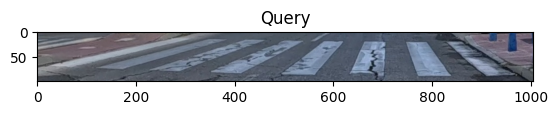

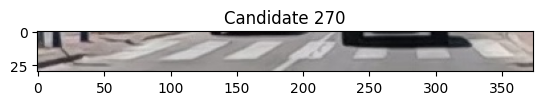

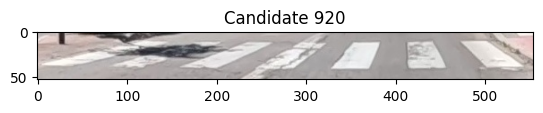

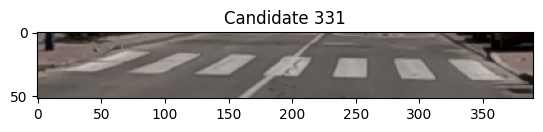

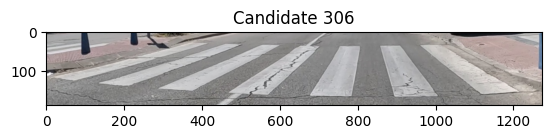

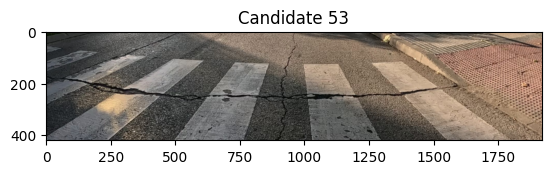

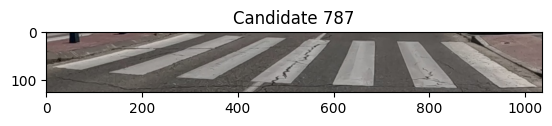

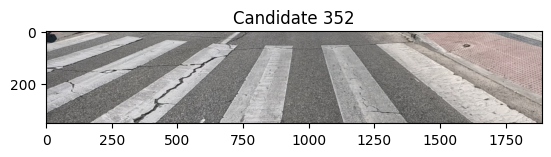

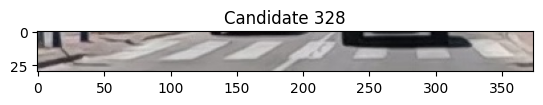

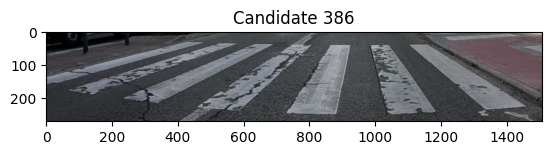

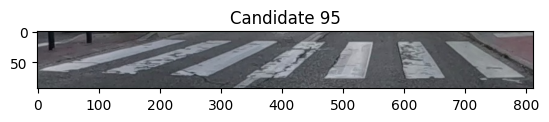

INFO:root:Top candidates for query 000002.jpg


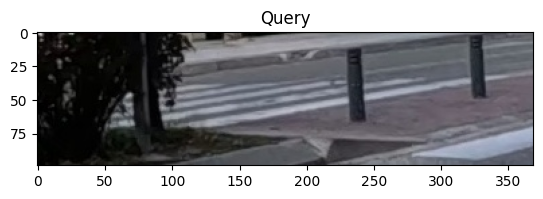

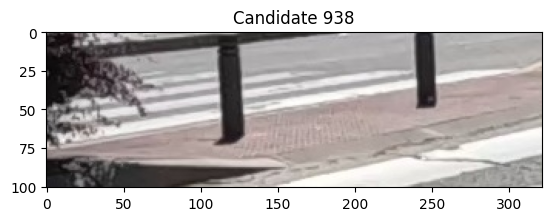

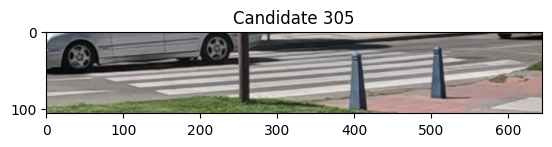

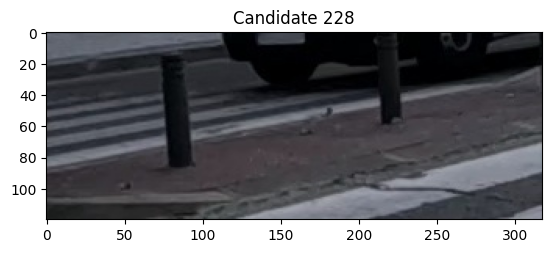

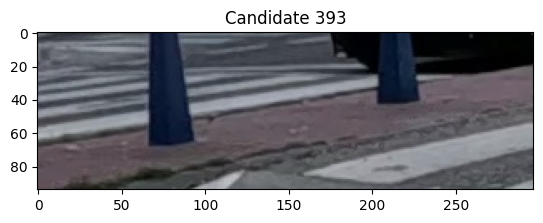

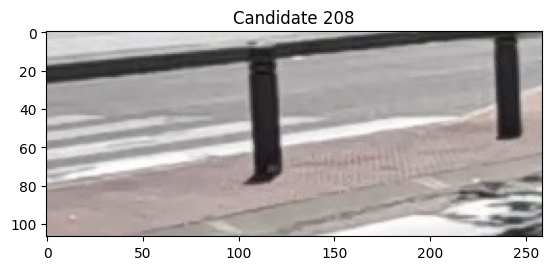

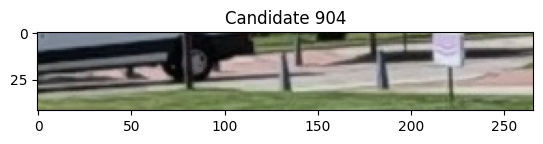

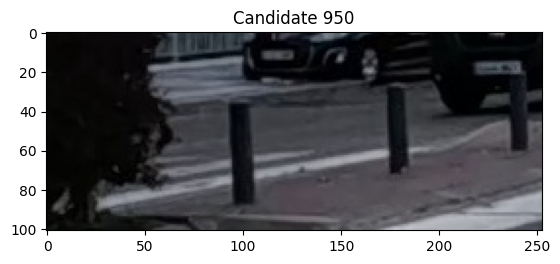

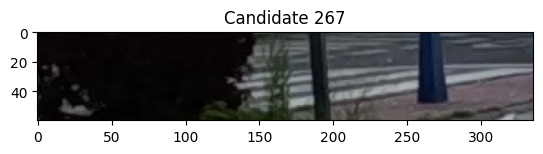

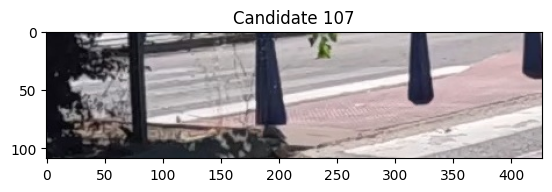

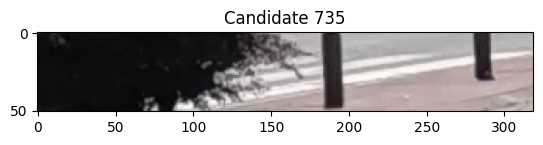

INFO:root:Top candidates for query 000003.jpg


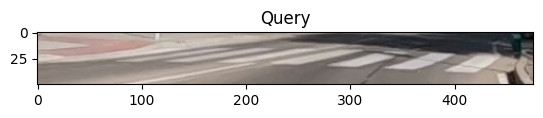

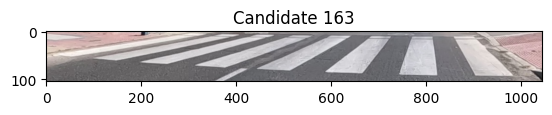

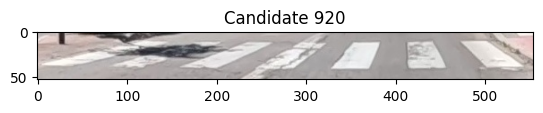

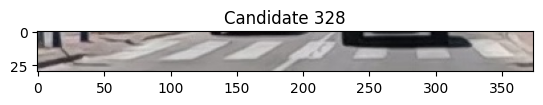

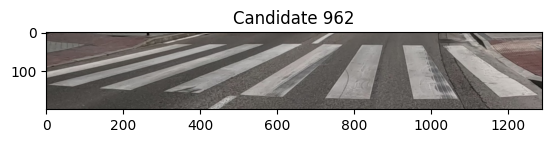

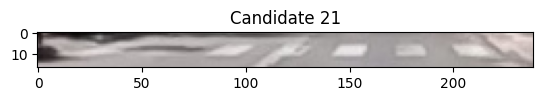

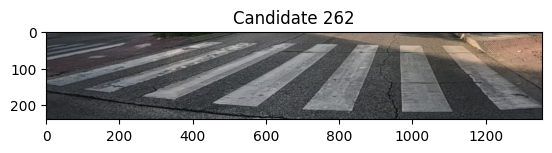

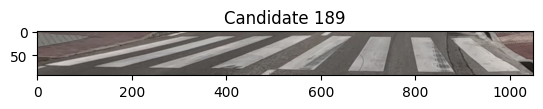

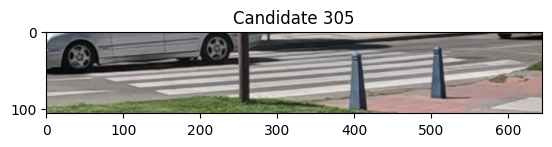

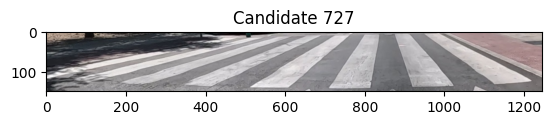

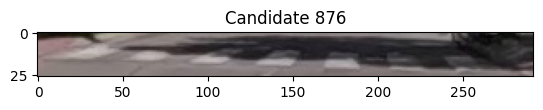

INFO:root:Top candidates for query 000004.jpg


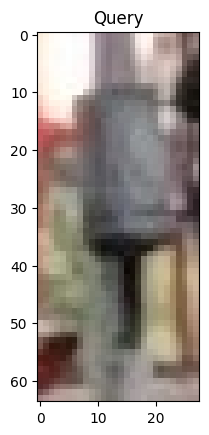

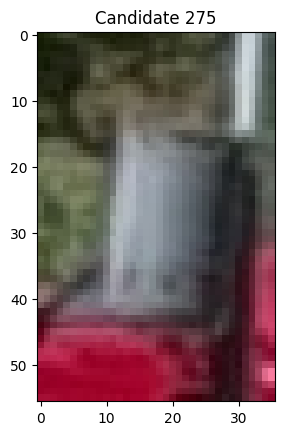

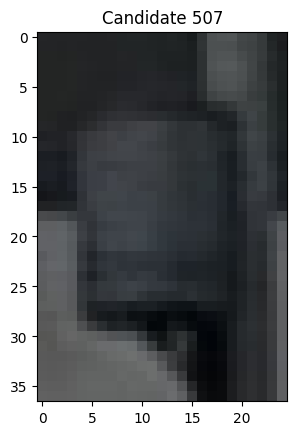

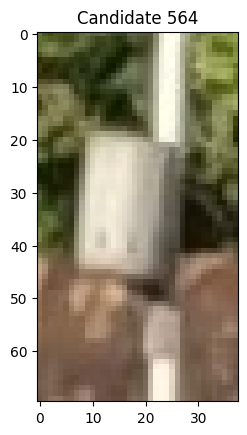

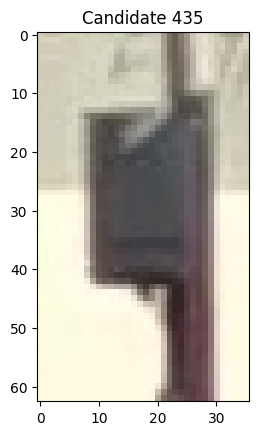

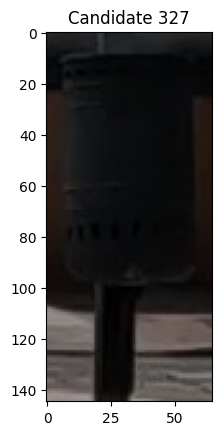

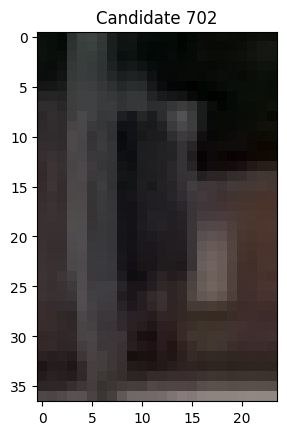

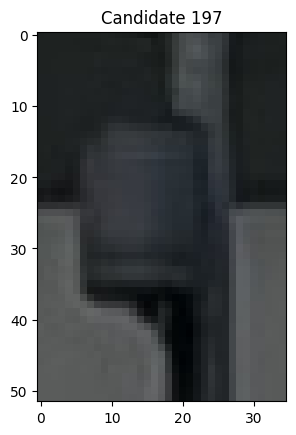

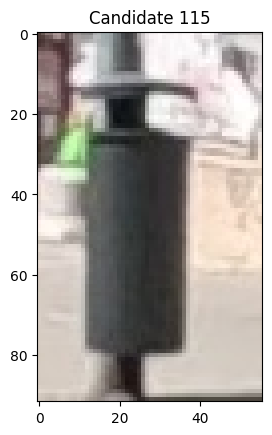

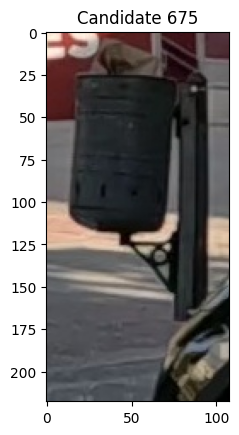

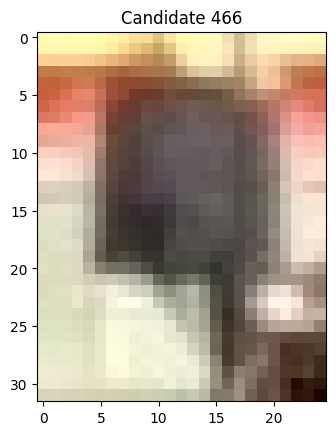

INFO:root:Top candidates for query 000005.jpg


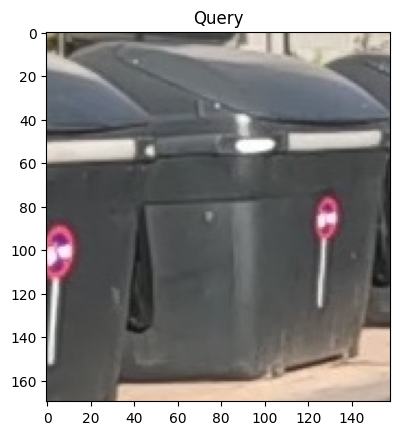

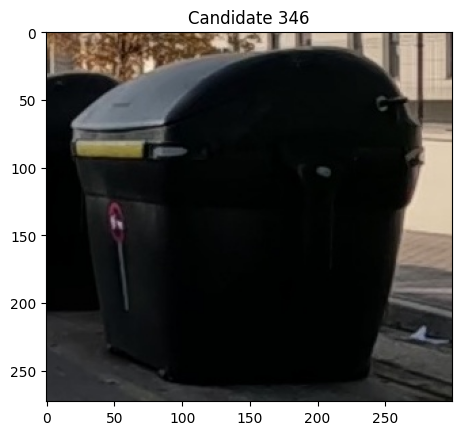

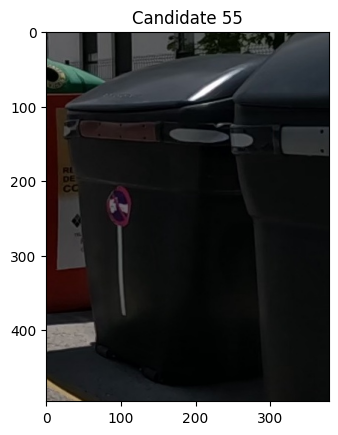

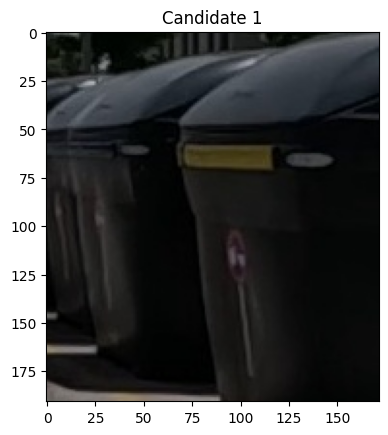

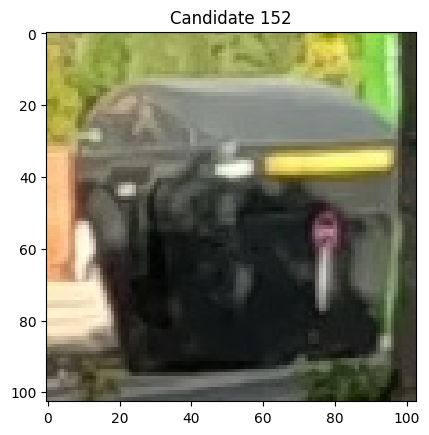

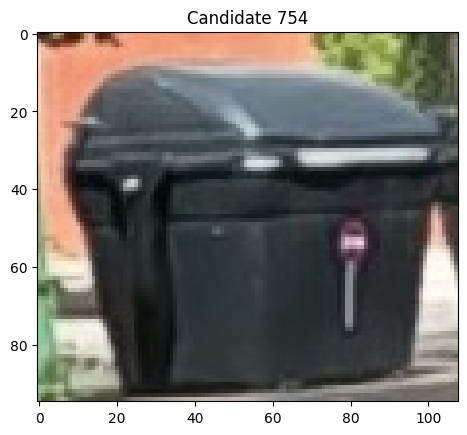

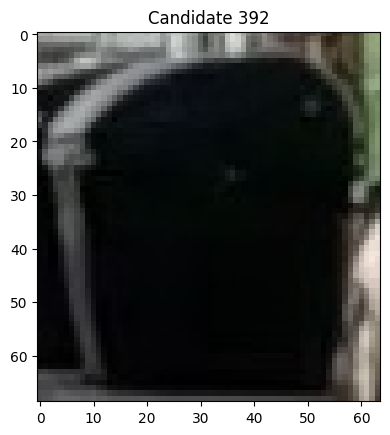

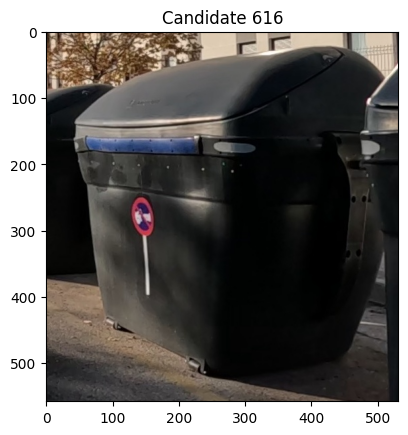

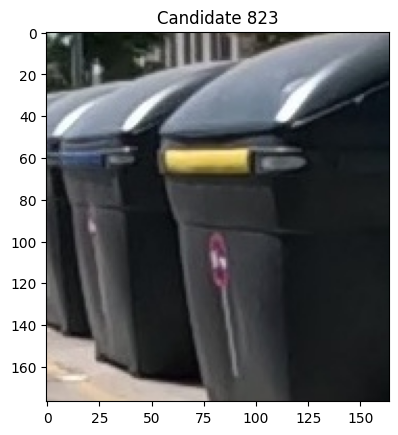

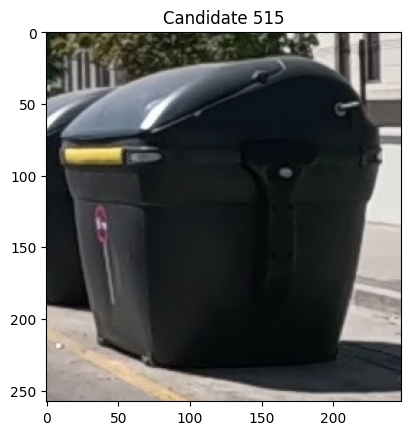

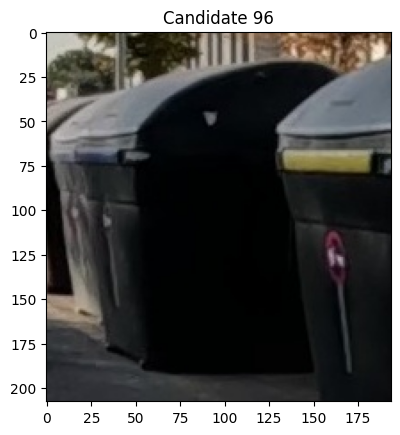

INFO:root:Top candidates for query 000006.jpg


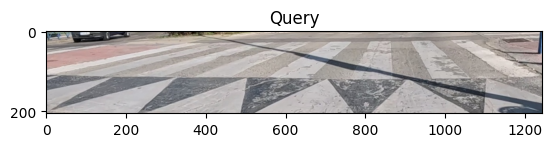

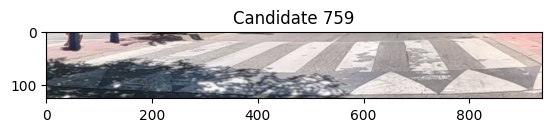

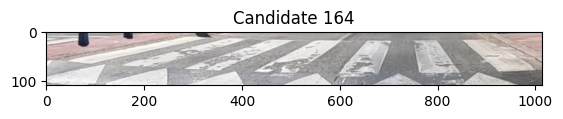

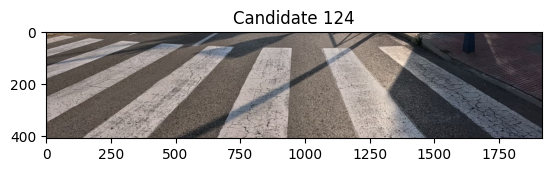

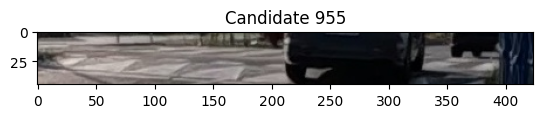

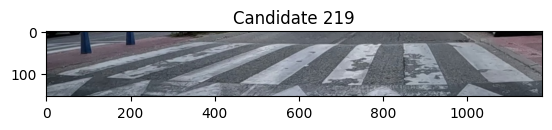

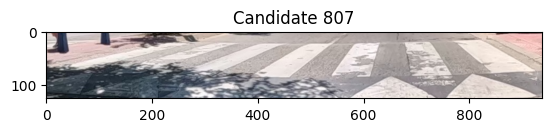

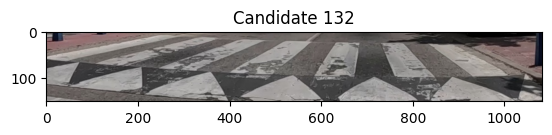

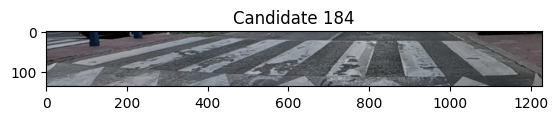

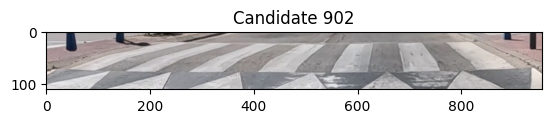

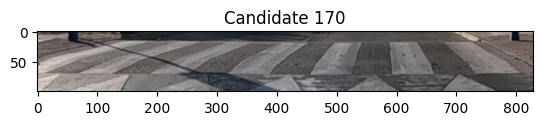

INFO:root:Top candidates for query 000007.jpg


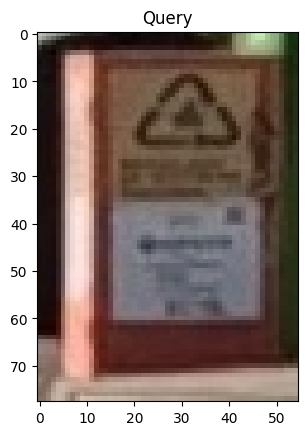

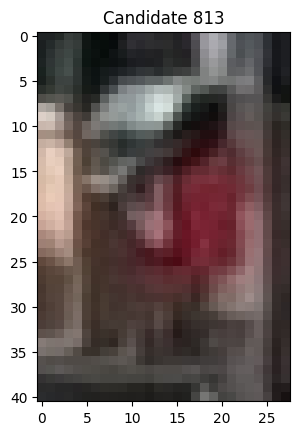

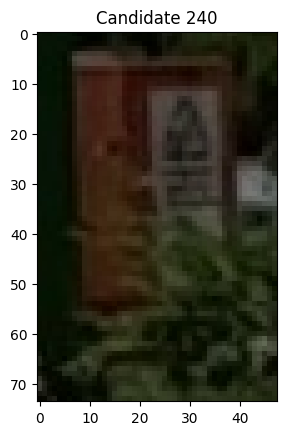

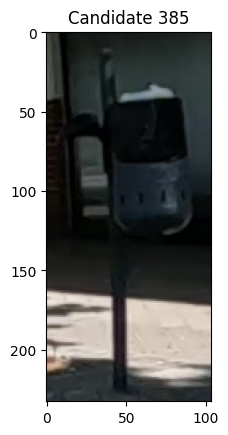

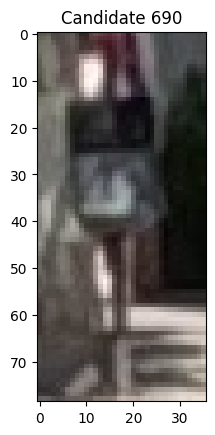

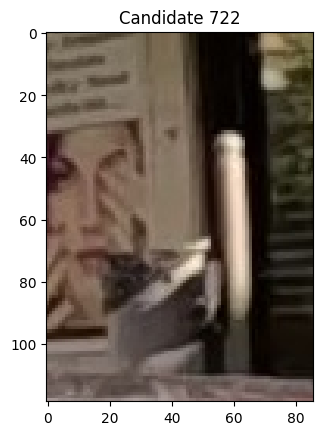

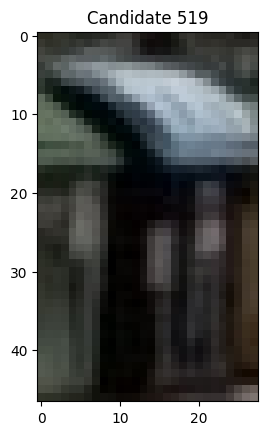

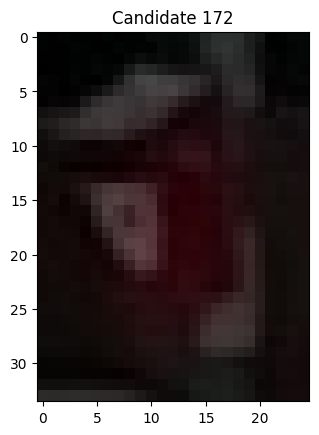

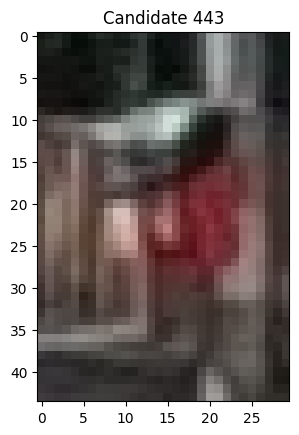

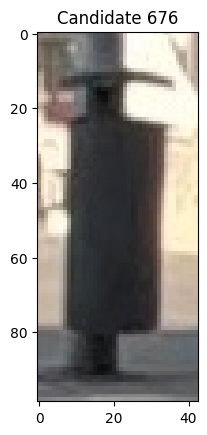

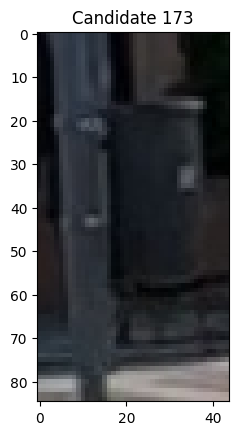

INFO:root:Top candidates for query 000008.jpg


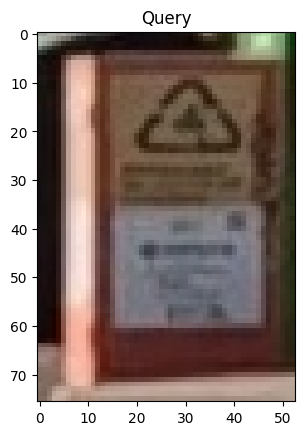

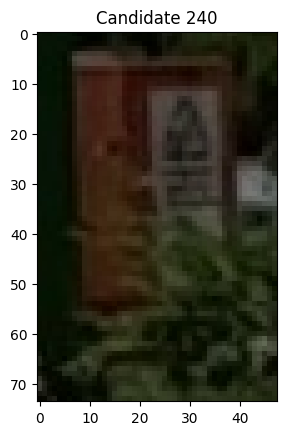

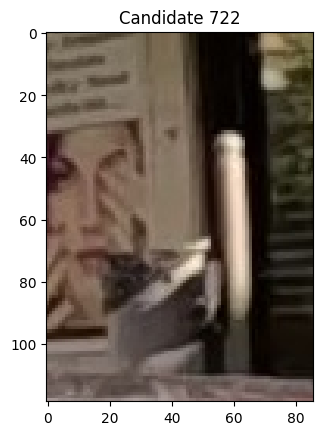

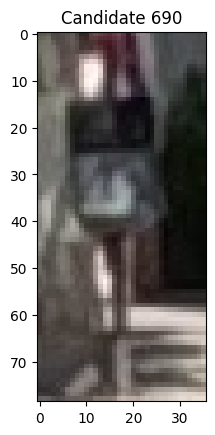

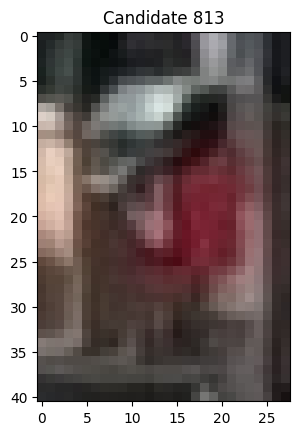

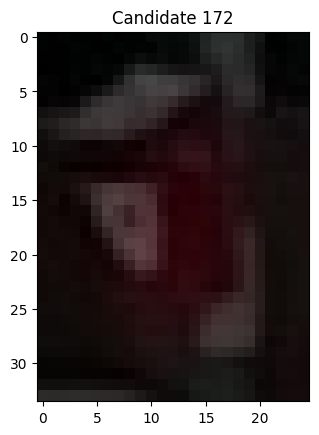

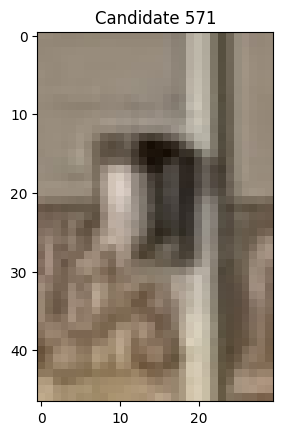

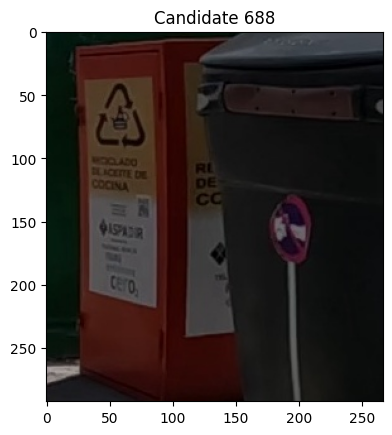

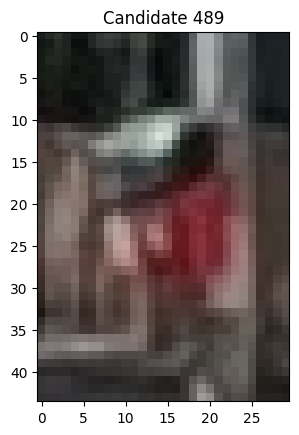

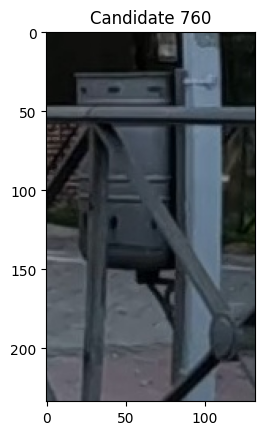

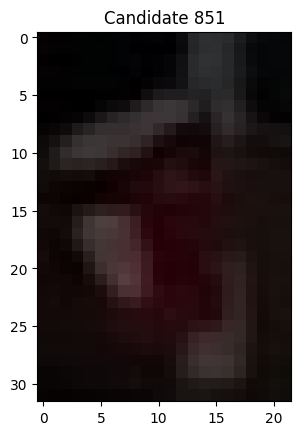

INFO:root:Top candidates for query 000009.jpg


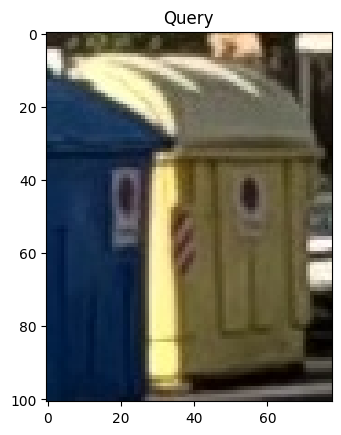

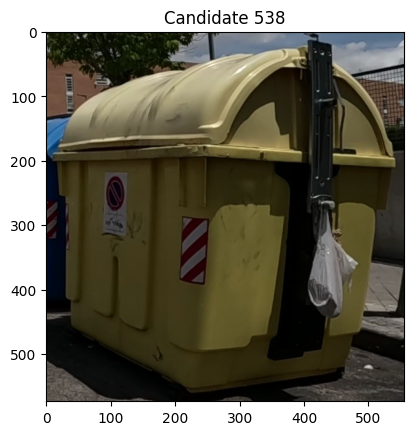

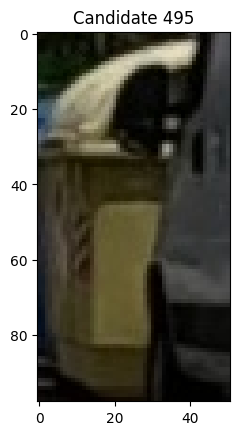

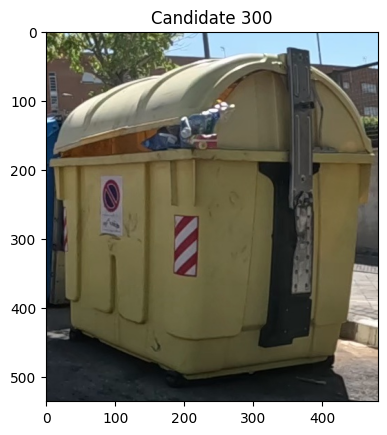

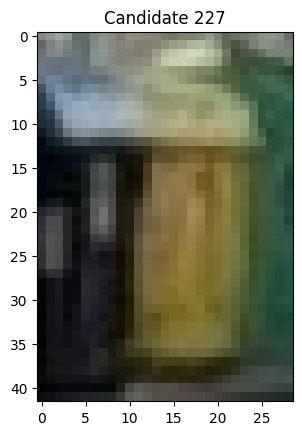

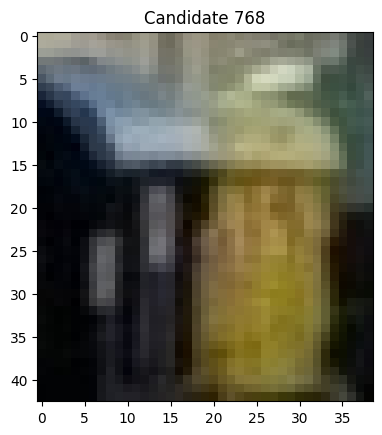

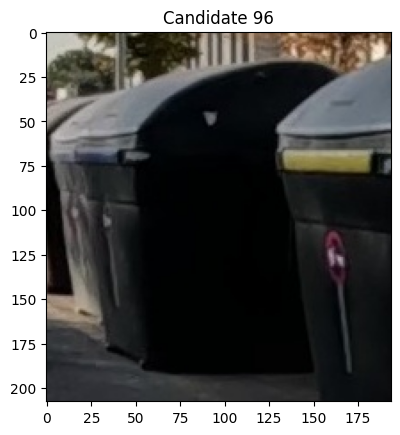

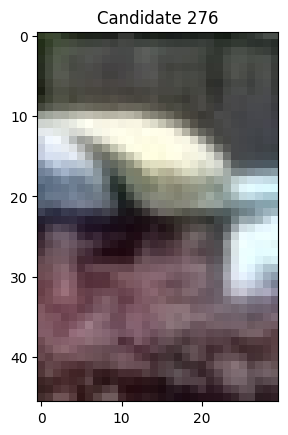

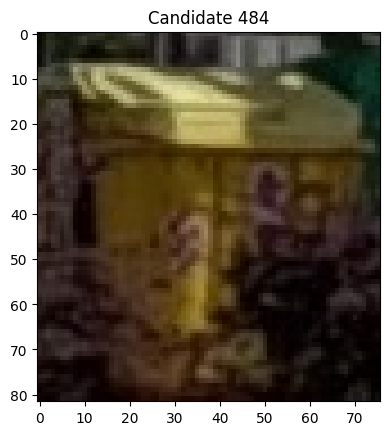

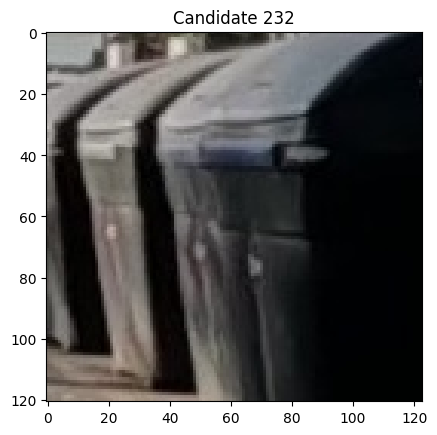

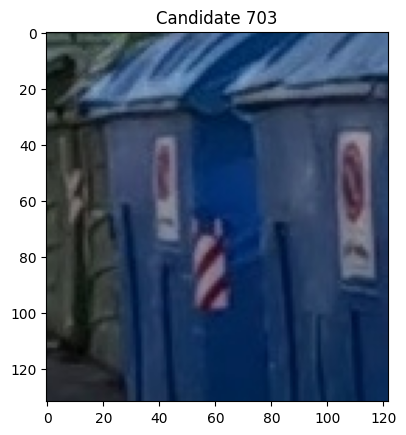

INFO:root:Top candidates for query 000010.jpg


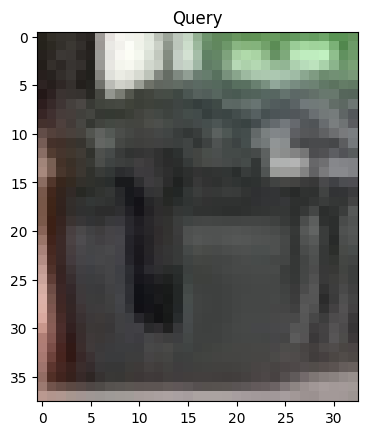

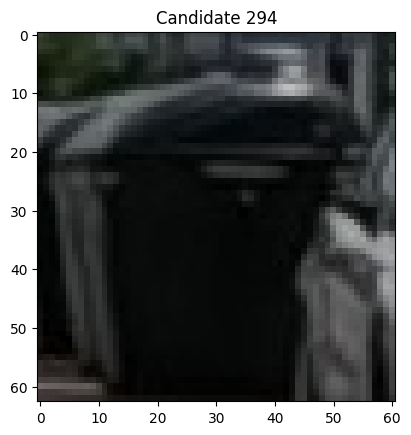

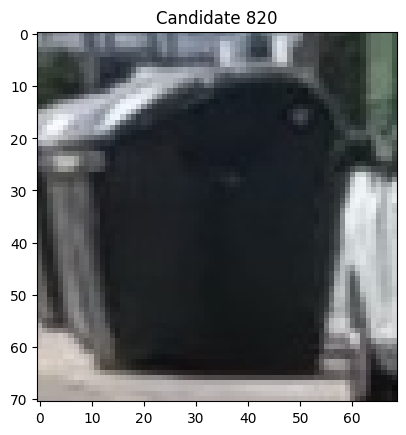

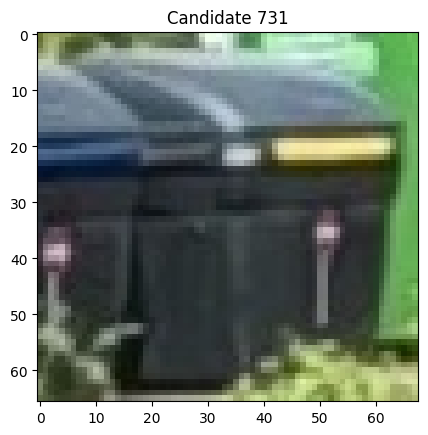

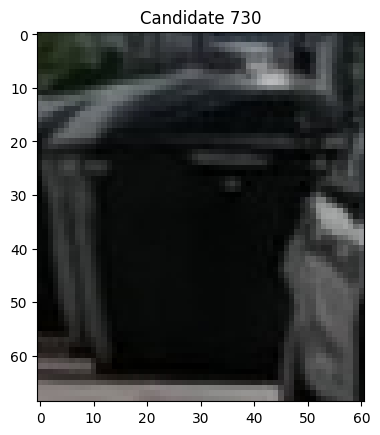

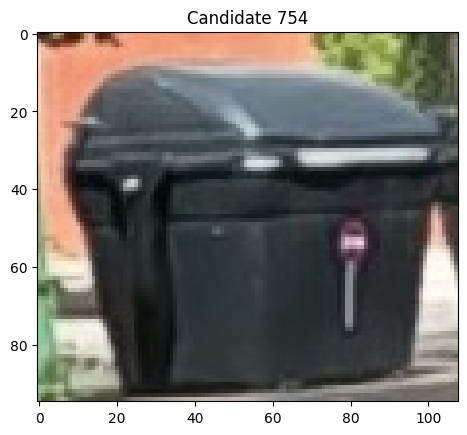

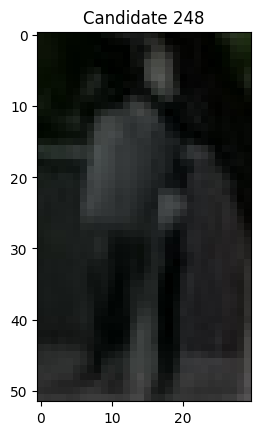

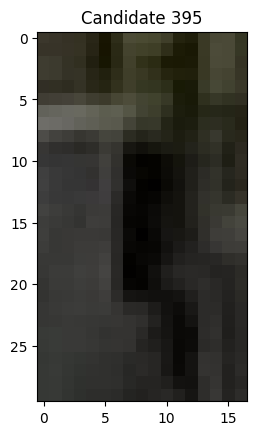

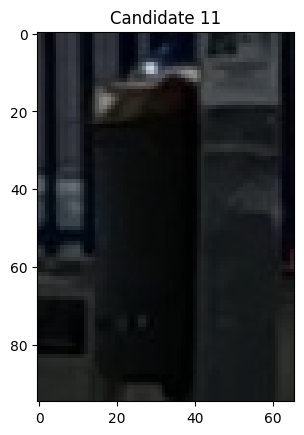

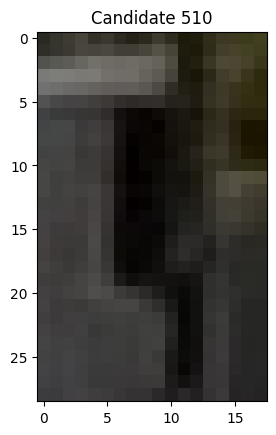

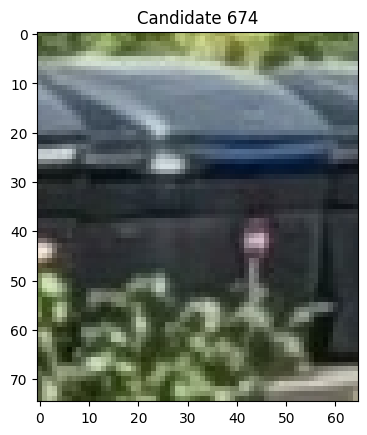

INFO:root:Top candidates for query 000011.jpg


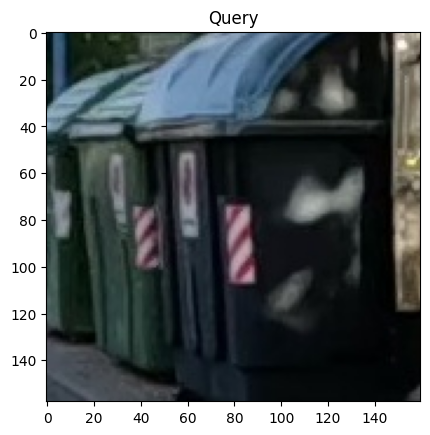

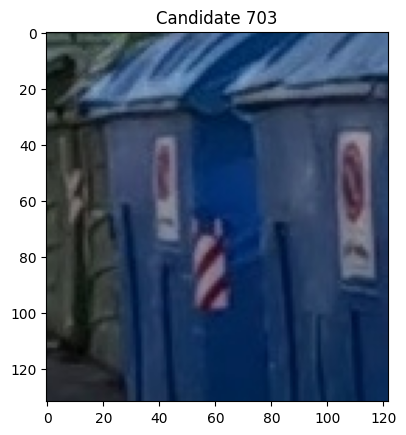

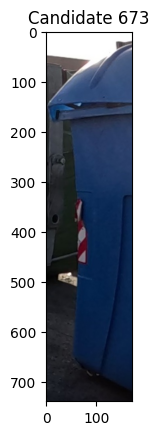

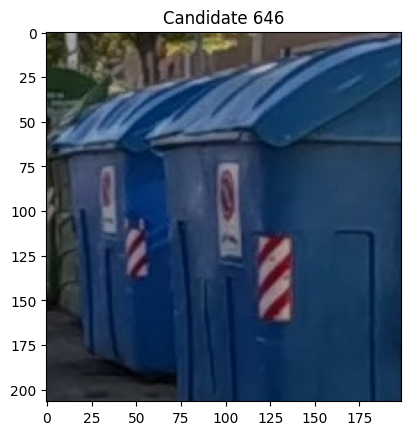

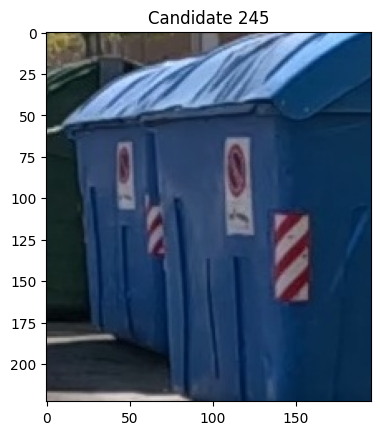

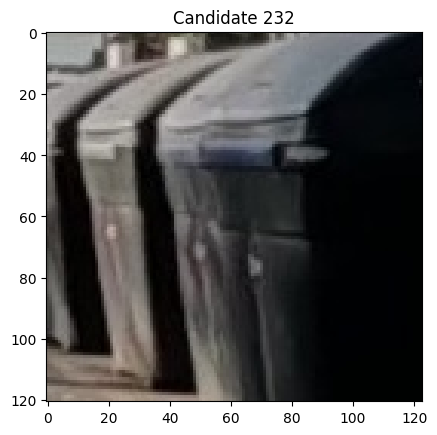

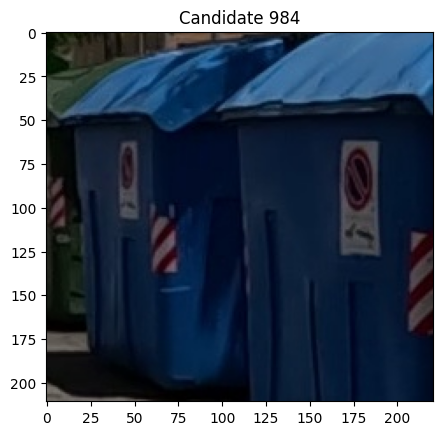

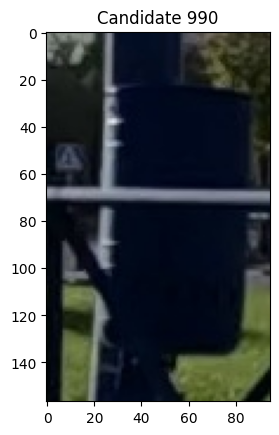

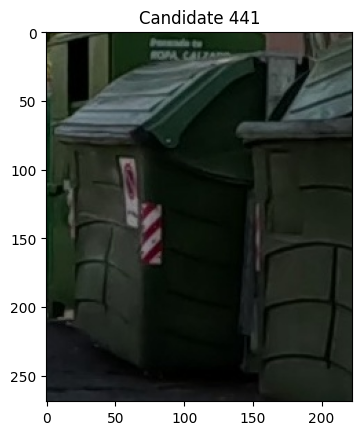

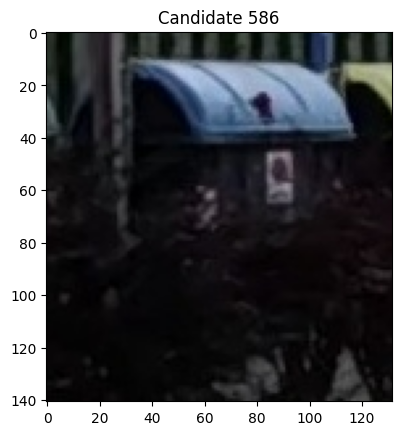

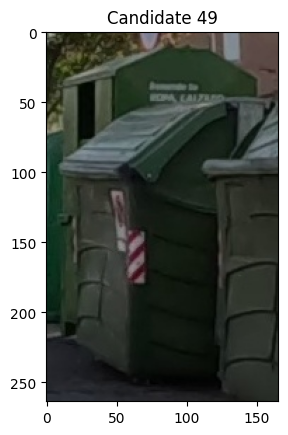

In [16]:
# Show some predictions
assert os.path.exists(submission_file_name)
df = pd.read_csv(submission_file_name)
assert df.shape[0] == num_query_base
assert df.shape[1] == 2

i: int = 0
for query_index, query_row in df.iterrows():
    logging.info(f"Top candidates for query {query_row['imageName']}")
    plt.imshow(plt.imread(f"assets/datasets/{dataset}/image_query/{query_row['imageName']}"))
    plt.title('Query')
    plt.show()

    for candidate_gallery_id in query_row['Corresponding Indexes'].split()[:10]:
        plt.imshow(plt.imread(f"assets/datasets/{dataset}/image_test/{int(candidate_gallery_id):06d}.jpg"))
        plt.title(f"Candidate {candidate_gallery_id}")
        plt.show()

    i += 1;
    if i > 10:
        break

# Submit

In [17]:
logging.info(f'Backuped everything to {experiment_id}')
!cp -r {model_path_b} {model_path_b}_backup_{experiment_id}
!cp -r {model_path_embedding_r} {model_path_embedding_r}_backup_{experiment_id}

INFO:root:Backuped everything to 1746609112
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
submission_message += f"; commit_hash: {subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()}"
submission_message += f"; hyperparameters_train_hash: {calculate_params_hash(hyperparams_train_b)}"
submission_message += f"; hyperparameters_test_hash: {calculate_params_hash(hyperparams_test_b)}"
submission_message += f"; matching_use_refinements: {matching_use_refinements}"
submission_message += f"; matching_use_text: {matching_use_text}"
submission_message += f"; embeddings_refinements_use_dino: {embeddings_refinements_use_dino}"
submission_message += f"; matching_use_percentile_fusion: {matching_use_percentile_fusion}"
submission_message += f"; experiment_ID: {experiment_id}"
logging.info(f'Submitting with message "{submission_message}"')

# Past results (they also appear in kaggle)
# 0.14045 | DSD refinement; commit_hash: 6a355affdb8ee8365325d8dd2aee8df03ea9b715; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; experiment_ID: 1746094978
# 0.15746 | DSD refinement; commit_hash: a5d60e0dd908ab82263bf647ec9dc746262a0546; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; experiment_ID: 1746185635
# 0.14758 | DSD refinement in gallery; commit_hash: a5d60e0dd908ab82263bf647ec9dc746262a0546; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; experiment_ID: 1746186369
# 0.03727 | No refinement just caption; commit_hash: a8a26bde273ea4f3c5b540d784d09e706f5d7d5e; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; experiment_ID: 1746190901
# 0.01921 | Refinement featurized with Dino; commit_hash: 1c865c3d6c329cf79c603b0e0f0e0ebf9a6686c8; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; experiment_ID: 1746205635
# 0.18669 | Just PAT; commit_hash: 1c865c3d6c329cf79c603b0e0f0e0ebf9a6686c8; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; matching_use_refinements: False; matching_use_text: False; embeddings_refinements_use_dino: False; experiment_ID: 1746207959; commit_hash: 1c865c3d6c329cf79c603b0e0f0e0ebf9a6686c8; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; matching_use_refinements: False; matching_use_text: False; embeddings_refinements_use_dino: False; experiment_ID: 1746207959
# 0.14701 | Percentile-matching; commit_hash: 1c865c3d6c329cf79c603b0e0f0e0ebf9a6686c8; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; matching_use_refinements: True; matching_use_text: False; embeddings_refinements_use_dino: False; matching_use_percentile_fusion: None; experiment_ID: 1746355049
# 0.07168 | Concatenation base+A+text; commit_hash: 1c865c3d6c329cf79c603b0e0f0e0ebf9a6686c8; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; matching_use_refinements: True; matching_use_text: True; embeddings_refinements_use_dino: False; matching_use_percentile_fusion: None; experiment_ID: 1746356444
# Submit the file to the competition
# Uncomment only for actual submissions!
api.competition_submit(submission_file_name, submission_message, competition_name)    

INFO:root:Submitting with message "Concatenation base+A+text; commit_hash: 98c60c2600cbfd206ac57ac33cd5395b882354c8; hyperparameters_train_hash: 8f10df35f3f22a7060923d11debd2f45; hyperparameters_test_hash: 92df54af27bbf9cfde3308cc811d1561; matching_use_refinements: True; matching_use_text: True; embeddings_refinements_use_dino: False; matching_use_percentile_fusion: None; experiment_ID: 1746609112"
